In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

Plotting from ../build/repeated_fullmap_noise0.3/ ...
Plotting from ../build/repeated_fullmap_noise0.2/ ...
Plotting from ../build/repeated_fullmap_noise0.1/ ...
Plotting from ../build/repeated_fullmap_noise0.05/ ...
Plotting from ../build/repeated_fullmap_noise0.01/ ...


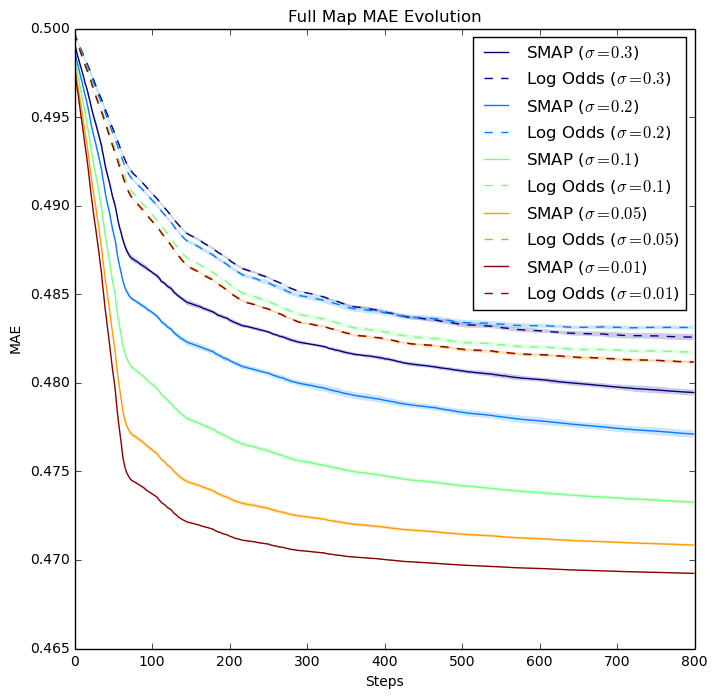

In [86]:
%matplotlib inline
fig, (ax) = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title("Full Map MAE Evolution")
ax.set_xlabel("Steps")
ax.set_ylabel("MAE")

def hash_position(x, y, z):
    return "%.2f %.2f %.2f" % (x, y, z)

def plot_rounds(directory_name, noise_std, color_smap="b", color_logodds="g"):    
    directory_name = "../build/%s/" % directory_name
    print "Plotting from %s ..." % directory_name
    filenames = sorted(
        glob.glob(directory_name + "*.bag"),
        key=lambda f: int(re.findall('([0-9]+)', f[len(directory_name):])[0]))
    
    err_belief = []
    err_logodds = []

    steps = 0

    for rnd, filename in enumerate(filenames):
#         print "Evaluating round %i (%s)..." % (rnd, filename)
        bag = rosbag.Bag(filename)
        stats = None
        for _, msg, _ in bag.read_messages(topics=['stats']):
            stats = msg
        bag.close()
        if stats is None:
            continue

        steps = stats.step        
        err_belief.append(stats.errorEvolutionBelief)
        err_logodds.append(stats.errorEvolutionLogOdds)
        #ax.plot(stats.errorEvolutionLogOdds, label=filename)
        
    err_belief = np.array(err_belief)
    err_logodds = np.array(err_logodds)
    
    std_belief = np.std(err_belief, axis=0)
    std_logodds = np.std(err_logodds, axis=0)
    avg_belief = np.mean(err_belief, axis=0)
    avg_logodds = np.mean(err_logodds, axis=0)
    
    x = list(range(steps))
    ax.fill_between(x, avg_belief-2*std_belief, avg_belief+2*std_belief, alpha=0.2, facecolor=color_smap, edgecolor='none', antialiased=True)
    ax.fill_between(x, avg_logodds-2*std_logodds, avg_logodds+2*std_logodds, alpha=0.2, facecolor=color_logodds, edgecolor='none', antialiased=True)

    ax.plot(avg_belief, label="SMAP ($\sigma = %s$)" % noise_std, color=color_smap)
    ax.plot(avg_logodds, label="Log Odds ($\sigma = %s$)" % noise_std, color=color_logodds, linestyle="dashed")
    
    
noise_intensities = ["0.3", "0.2", "0.1", "0.05", "0.01"]
gradient = np.linspace(0, 0.99, len(noise_intensities))
colors = [cm.jet(x) for x in gradient]
for i, ni in enumerate(noise_intensities):
    plot_rounds("repeated_fullmap_noise" + ni, ni, colors[i], colors[i])

ax.legend()
plt.savefig("mae_noises.pdf")

Plotting from ../build/different_maps/ ...


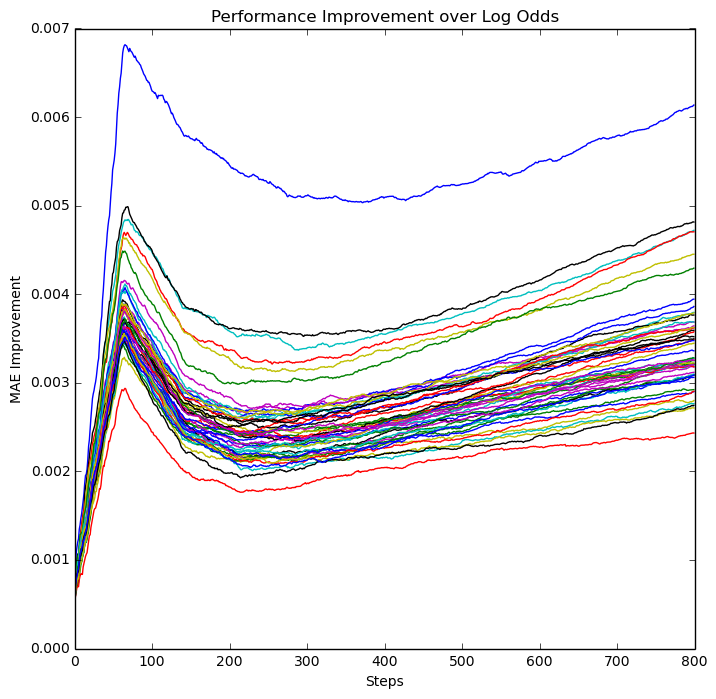

In [87]:
%matplotlib inline
fig, (ax) = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title("Performance Improvement over Log Odds")
ax.set_xlabel("Steps")
ax.set_ylabel("MAE Improvement")
  
directory_name = "../build/different_maps/"
print "Plotting from %s ..." % directory_name
filenames = sorted(
    glob.glob(directory_name + "*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len(directory_name):])[0]))

steps = 0

for rnd, filename in enumerate(filenames):
#         print "Evaluating round %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue

    steps = stats.step        
    
    err_belief = np.array(stats.errorEvolutionBelief)
    err_logodds = np.array(stats.errorEvolutionLogOdds)
    ax.plot(err_logodds - err_belief, label=filename)
    
plt.savefig("perf_improvement.pdf")